In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Transactions.csv to Transactions.csv
Saving Products.csv to Products.csv
Saving Customers.csv to Customers.csv


In [3]:

# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [4]:
# Merge datasets
data = transactions.merge(customers, on="CustomerID", how="left")
data = data.merge(products, on="ProductID", how="left")

In [5]:
# Feature Engineering: Aggregate features for each customer
customer_features = data.groupby("CustomerID").agg(
    total_purchases=("Quantity", "sum"),
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    preferred_category=("Category", lambda x: x.mode()[0]),
    region=("Region", "first")
).reset_index()

In [6]:
# One-hot encode categorical features
customer_features = pd.get_dummies(customer_features, columns=["preferred_category", "region"], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numeric_features = ["total_purchases", "total_spent", "avg_transaction_value"]
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

In [7]:
# Clustering using KMeans
k = 5  # Number of clusters (adjustable between 2 and 10)
kmeans = KMeans(n_clusters=k, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(customer_features.drop("CustomerID", axis=1))

# Evaluate Clustering Metrics
cluster_data = customer_features.drop("CustomerID", axis=1)
db_index = davies_bouldin_score(cluster_data, customer_features["Cluster"])
silhouette_avg = silhouette_score(cluster_data, customer_features["Cluster"])

In [8]:
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 1.1154536681970086
Silhouette Score: 0.3299827913922849


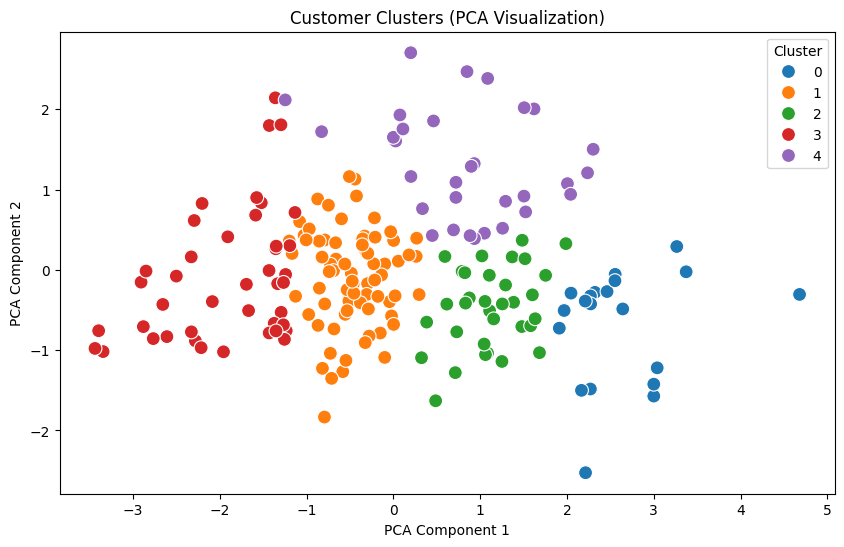

In [9]:
# Visualize Clusters using PCA
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features.drop(["CustomerID", "Cluster"], axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features_pca[:, 0],
    y=customer_features_pca[:, 1],
    hue=customer_features["Cluster"],
    palette="tab10",
    s=100
)
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


In [10]:
# Save Clustering Results
customer_features[["CustomerID", "Cluster"]].to_csv("Customer_Clusters.csv", index=False)
print("Clustering results saved to Customer_Clusters.csv")

Clustering results saved to Customer_Clusters.csv
